In [15]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense ,MaxPooling2D, Input, Flatten
import tensorflow as tf

In [23]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [24]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [37]:
!tar -xf lfw.tgz

In [38]:
os.listdir('lfw')

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    print(os.listdir(dir_path))
    if os.path.isdir(dir_path):  # Check if it is a directory
        for file in os.listdir(dir_path):
            # print(file)
            EX_PATH = os.path.join(dir_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            try:
                # print(f"Moving {EX_PATH} to {NEW_PATH}")
                os.replace(EX_PATH, NEW_PATH)
                # Uncomment the line below if you want confirmation of replacement
                # print(f"Replaced: {EX_PATH} -> {NEW_PATH}")
            except Exception as e:
                # print(f"Failed to move {EX_PATH} to {NEW_PATH}: {e}")

In [41]:
import uuid

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))


'data\\anchor\\19bf5771-4ce3-11ef-838f-f0a6548976ec.jpg'

In [57]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()  
    frame = frame[120:120+250,200:200+250, :]
     

    cv2.imshow('Image Collection', frame)
        # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
cv2.destroyAllWindows()

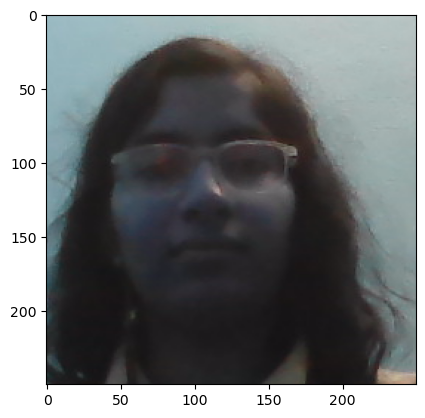

In [54]:
plt.imshow(frame)

In [58]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(500)

In [59]:

dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\8f3a7176-4ce7-11ef-a5b0-f0a6548976ec.jpg'


In [29]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [62]:
img = preprocess('data\\anchor\\8f3a7176-4ce7-11ef-a5b0-f0a6548976ec.jpg')

In [63]:
img.numpy().max() 

0.9397059

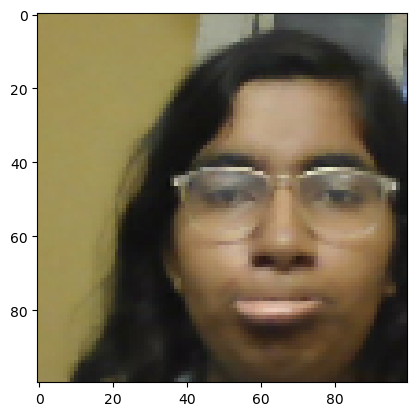

In [64]:
plt.imshow(img)

In [88]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [89]:

samples = data.as_numpy_iterator()

In [90]:
exampple = samples.next()
exampple

(b'data\\anchor\\b8a775a3-4ce7-11ef-a8a1-f0a6548976ec.jpg',
 b'data\\positive\\95ccae2f-4ce7-11ef-aa16-f0a6548976ec.jpg',
 1.0)

In [91]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
res = preprocess_twin(*exampple)

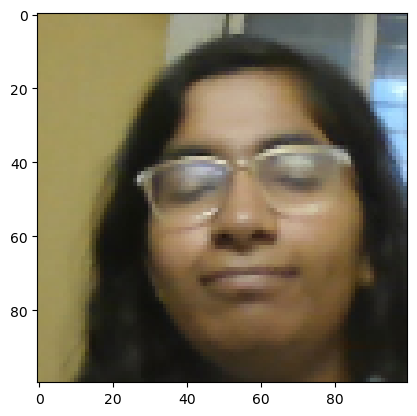

In [92]:
plt.imshow(res[1])


In [93]:
res[2]

1.0

In [94]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [122]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [95]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [76]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [78]:
embedding = make_embedding()

In [79]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        # print(input_embedding)
        # input_embedding=np.array(input_embedding)
        # validation_embedding=np.array(validation_embedding)
        input_embedding=tf.convert_to_tensor(input_embedding,dtype=tf.float32)
        validation_embedding=tf.convert_to_tensor(validation_embedding,dtype=tf.float32)
        distance = tf.math.abs(input_embedding - validation_embedding)
        return tf.squeeze(distance, axis=0)

In [145]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()
siamese_model.summary()



Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_11 (L1Dist) │ (None, 4096)      │          0 │ embedding[20][0], │
│                     │                   │            │ embedding[21][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [147]:
test_batch = train_data.as_numpy_iterator()
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [148]:

test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]

y = batch_1[2]


y

array([0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

In [162]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1, values=[('loss', loss.numpy())])
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        



In [214]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/stepp - loss: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/stepp - loss: 0.01
1/1 ━━━━━━━━

In [215]:

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

y_true



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


array([1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [216]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()


1.0

In [217]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [218]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1.0 1.0


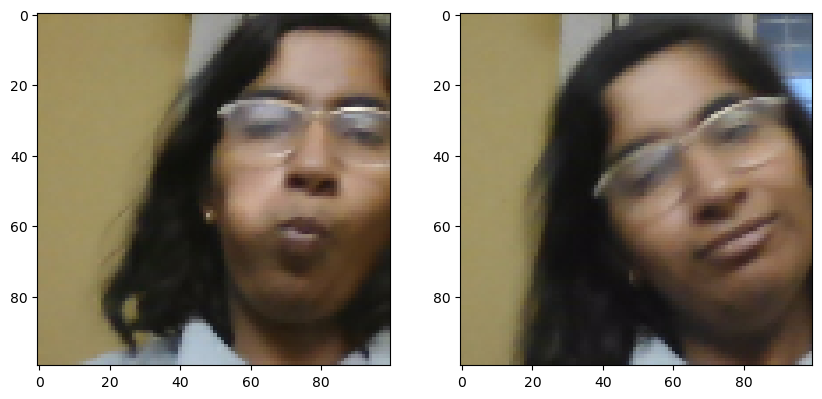

In [219]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [220]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [18]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [222]:

# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


array([[9.9998933e-01],
       [1.1599581e-03],
       [9.9998838e-01],
       [9.9935949e-01],
       [9.9627399e-01],
       [1.1208400e-03],
       [6.1208972e-05],
       [1.7360337e-04],
       [2.6058671e-03],
       [2.0860940e-04],
       [9.9814135e-01],
       [8.9583526e-05]], dtype=float32)

In [223]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_13 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [224]:
# application_data\verification_images

In [19]:
os.listdir(os.path.join('application_data', 'verification_images'))

['9636dc60-4ce7-11ef-a83b-f0a6548976ec.jpg',
 '976eab3d-4ce7-11ef-8c10-f0a6548976ec.jpg',
 '977cf896-4ce7-11ef-a592-f0a6548976ec.jpg',
 '981ea30a-4ce7-11ef-ab7c-f0a6548976ec.jpg',
 '9b026ee2-4ce7-11ef-9ef5-f0a6548976ec.jpg',
 '9bb6f0e8-4ce7-11ef-9990-f0a6548976ec.jpg',
 '9bbba5ae-4ce7-11ef-b81f-f0a6548976ec.jpg',
 '9bf4b987-4ce7-11ef-9e06-f0a6548976ec.jpg',
 '9c5d0928-4ce7-11ef-9f4e-f0a6548976ec.jpg',
 '9c61db0f-4ce7-11ef-80d2-f0a6548976ec.jpg',
 '9cb29405-4ce7-11ef-92b5-f0a6548976ec.jpg',
 '9e642b35-4ce7-11ef-8ae9-f0a6548976ec.jpg',
 '9e832e52-4ce7-11ef-a1c5-f0a6548976ec.jpg',
 '9e917f38-4ce7-11ef-9012-f0a6548976ec.jpg',
 'a10f06e2-4ce7-11ef-a363-f0a6548976ec.jpg',
 'a113cd38-4ce7-11ef-8738-f0a6548976ec.jpg',
 'a13c40e5-4ce7-11ef-bf9e-f0a6548976ec.jpg',
 'be31e469-4ce7-11ef-baaa-f0a6548976ec.jpg',
 'c0d921a9-4ce7-11ef-bf4e-f0a6548976ec.jpg',
 'c2be95d9-4ce7-11ef-a0c1-f0a6548976ec.jpg',
 'c2ec0de0-4ce7-11ef-af65-f0a6548976ec.jpg',
 'c2f5697f-4ce7-11ef-8fe2-f0a6548976ec.jpg',
 'c2fa3c3e

In [20]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [21]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\9636dc60-4ce7-11ef-a83b-f0a6548976ec.jpg
application_data\verification_images\976eab3d-4ce7-11ef-8c10-f0a6548976ec.jpg
application_data\verification_images\977cf896-4ce7-11ef-a592-f0a6548976ec.jpg
application_data\verification_images\981ea30a-4ce7-11ef-ab7c-f0a6548976ec.jpg
application_data\verification_images\9b026ee2-4ce7-11ef-9ef5-f0a6548976ec.jpg
application_data\verification_images\9bb6f0e8-4ce7-11ef-9990-f0a6548976ec.jpg
application_data\verification_images\9bbba5ae-4ce7-11ef-b81f-f0a6548976ec.jpg
application_data\verification_images\9bf4b987-4ce7-11ef-9e06-f0a6548976ec.jpg
application_data\verification_images\9c5d0928-4ce7-11ef-9f4e-f0a6548976ec.jpg
application_data\verification_images\9c61db0f-4ce7-11ef-80d2-f0a6548976ec.jpg
application_data\verification_images\9cb29405-4ce7-11ef-92b5-f0a6548976ec.jpg
application_data\verification_images\9e642b35-4ce7-11ef-8ae9-f0a6548976ec.jpg
application_data\verification_images\9e832e52-4ce7-11ef-a1c5-f0a

In [22]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## This is for one of my photo which is true

In [229]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━

In [230]:

np.sum(np.squeeze(results) > 0.9)

48

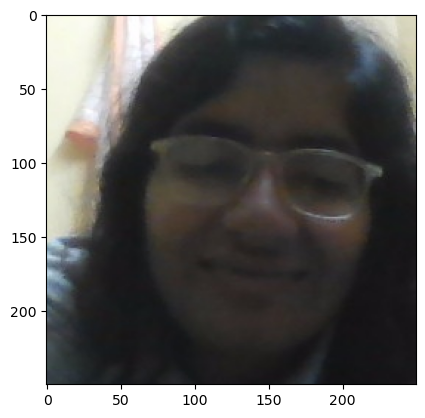

In [233]:
import matplotlib.image as img 
  
# reading the image 
testImage = img.imread('application_data\input_image\input_image.jpg') 
  
# displaying the image 
plt.imshow(testImage) 

In [231]:
results

[array([[0.55474097]], dtype=float32),
 array([[0.9999585]], dtype=float32),
 array([[0.9985508]], dtype=float32),
 array([[0.94576734]], dtype=float32),
 array([[0.99999756]], dtype=float32),
 array([[0.72793645]], dtype=float32),
 array([[0.9187349]], dtype=float32),
 array([[0.99997723]], dtype=float32),
 array([[0.9999956]], dtype=float32),
 array([[0.9999983]], dtype=float32),
 array([[0.99982905]], dtype=float32),
 array([[0.9999972]], dtype=float32),
 array([[0.999776]], dtype=float32),
 array([[0.9999372]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.99992424]], dtype=float32),
 array([[0.9999961]], dtype=float32),
 array([[0.9999943]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.99992085]], dtype=float32),
 array([[0.99943054]], dtype=float32)

## For other random image

In [234]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━

In [235]:
np.sum(np.squeeze(results) > 0.9)

2

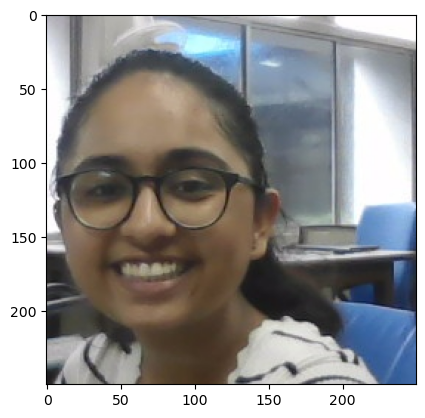

In [236]:
import matplotlib.image as img 
  
# reading the image 
testImage = img.imread('application_data\input_image\input_image.jpg') 
  
# displaying the image 
plt.imshow(testImage) 

In [237]:
results

[array([[0.99229205]], dtype=float32),
 array([[0.00844764]], dtype=float32),
 array([[0.0103919]], dtype=float32),
 array([[0.8378068]], dtype=float32),
 array([[0.0325191]], dtype=float32),
 array([[0.9563103]], dtype=float32),
 array([[0.88702846]], dtype=float32),
 array([[0.00852992]], dtype=float32),
 array([[0.05358309]], dtype=float32),
 array([[0.06637628]], dtype=float32),
 array([[0.00912383]], dtype=float32),
 array([[0.03040844]], dtype=float32),
 array([[0.01604465]], dtype=float32),
 array([[0.00745226]], dtype=float32),
 array([[0.5739689]], dtype=float32),
 array([[0.52808183]], dtype=float32),
 array([[0.00287633]], dtype=float32),
 array([[0.00768115]], dtype=float32),
 array([[0.01044293]], dtype=float32),
 array([[0.09584224]], dtype=float32),
 array([[0.19588451]], dtype=float32),
 array([[0.43653885]], dtype=float32),
 array([[0.25323385]], dtype=float32),
 array([[0.14585035]], dtype=float32),
 array([[0.0053036]], dtype=float32),
 array([[0.0085156]], dtype=flo

### This clearly shows that my image had a 48 images with greter than 90 percent overlap but with someone's else image the overlap was way lesser hence the model is working properly

### only for video purposes

In [43]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━

In [44]:
np.sum(np.squeeze(results) > 0.5)

0

In [45]:
results

[array([[0.1675702]], dtype=float32),
 array([[0.0002373]], dtype=float32),
 array([[0.00019125]], dtype=float32),
 array([[0.01519344]], dtype=float32),
 array([[0.0001249]], dtype=float32),
 array([[0.04827458]], dtype=float32),
 array([[0.01737912]], dtype=float32),
 array([[0.00010561]], dtype=float32),
 array([[0.00038366]], dtype=float32),
 array([[0.00038924]], dtype=float32),
 array([[0.00010064]], dtype=float32),
 array([[0.00040793]], dtype=float32),
 array([[0.00019553]], dtype=float32),
 array([[0.00013696]], dtype=float32),
 array([[0.00264933]], dtype=float32),
 array([[0.00230954]], dtype=float32),
 array([[7.0945614e-05]], dtype=float32),
 array([[0.00023063]], dtype=float32),
 array([[0.00041737]], dtype=float32),
 array([[0.00058935]], dtype=float32),
 array([[0.00165611]], dtype=float32),
 array([[0.00452182]], dtype=float32),
 array([[0.00198943]], dtype=float32),
 array([[0.002177]], dtype=float32),
 array([[0.00030618]], dtype=float32),
 array([[0.00044591]], dtyp